The transfer function for the causal LTI system with a realization $(A, B, C, D)$ is given by
\begin{equation*}
    H(s) = C(sI_{n} - A)^{-1}B.
\end{equation*}
Notice that $H(s) = Cv(s)$, where $v(s)$ is the solution of a parametrized linear coercive model
\begin{equation}
    a(v, w; s) = l(w),
\end{equation}
where $a(v, w; s) = w^{*}(sI_{n} - A)v$ and $l(w) = w^{*}B$. In other words, we replace the matrix computation of $(sI_{n} - A)^{-1}B$ with a parametrized model (1). However, if one wants to apply this to the Iterative rational Krylov algorithm (IRKA), then the following matrix computations must be done to construct the projection matrices $V$ and $W$:
\begin{equation*}
    (-\mu_{i}I_{n} - A)^{-1}B\hat{b}_{i}, \quad \text{and} \quad (-\mu_{i}I_{n} - A)^{-*}C^{T}\hat{c}_{i} \quad \text{for } i = 1,\ldots,r,
\end{equation*}
where $-\mu_{i}, \hat{c}_{i}, \hat{b}_{i}$ are some initial interpolation data and $0 < r \leq n$ is the desired order of approximating ROM. So, we have decided to solve two parametrized linear coercive models to construct projection matrices $V$ and $W$:
\begin{equation}
    a_{1}(v_{1}, w; s) = l_{1}(w) \quad \text{and} \quad a_{2}(v_{2}, w; s) = l_{2}(w),
\end{equation}
where $a_{1}(v_{1}, w; s) = w^{*}(sI_{n} - A)v_{1}$ and $l_{1}(w) = w^{*}B$, and $a_{2}(v_{2}, w; s) = w^{*}(sI_{n} - A)^{*}v_{2}$ and $l_{2}(w) = w^{*}C^{T}$, and solutions to these parametrized linear coercive models are
\begin{equation*}
    v_{1}(s) = (sI_{n} - A)^{-1}B \quad \text{and} \quad v_{2}(s) = (sI_{n} - A)^{-*}C^{T}.
\end{equation*}
Therefore, knowing $v_{1}(\mu_{i})$ and $v_{2}(\mu_{i})$ for $i = 1, \ldots, r$ will suffice for constructing the projection matrices $V$ and $W$. Also, note that these two FOMs are parameter-separable, i.e.,
\begin{equation*}
    a_{1}(v_{1},w;s) = w^{*}(sI_{n} - A)v_{1} = sw^{*}I_{n}v_{1} - w^{*}Av_{1}  \quad  a_{2}(v_{2},w;s) = w^{*}(sI_{n} - A)^{*}v_{2} = \overline{s}w^{*}I_{n}v_{2} - w^{*}A^{*}v_{2}.
\end{equation*}

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from pymor.basic import *
from pymor.models.basic import StationaryModel
from pymor.operators.constructions import LincombOperator
from pymor.operators.numpy import NumpyMatrixOperator
from pymor.parameters.functionals import ProjectionParameterFunctional
from pymor.vectorarrays.numpy import NumpyVectorSpace

### Constructing a stationary model
Let us construct a stationary model of the following parametrized linear coercive model using `pyMOR`:
\begin{equation}
    a(v, w; s) = l(w),
\end{equation}
where $a(v, w; s) = w^{*}(sI_{n} - A)v$ and $l(w) = w^{*}B$.

In [178]:
def MatrixModel(A, B, dim: int):

    '''
    This function create a stationary model of the following linear coercive model derived for the given two matrices A and B:
    
        a(v, w; s) =w^{*}(sI_{n} - A)v and l(w) = w^{*}B.
    '''
    
    # Create Numpy vector space
    vector_space = NumpyVectorSpace(dim)

    # Define NumpyMatrixOperators
    I_op = NumpyMatrixOperator(np.eye(dim))

    if isinstance(A, np.ndarray) and isinstance(B, np.ndarray):
        A_op = NumpyMatrixOperator(A)
        B_op = NumpyMatrixOperator(B.reshape(-1, 1))
    else:
        A_op = A
        B_op = B       

    # Define parameter functional for 's'
    s_param = ProjectionParameterFunctional('s', 1)

    # Define bilinear form a(v, w; s) = w^* (sI - A)v
    a_op = LincombOperator([I_op, A_op], [s_param, -1])

    # Define linear functional l(w) = w^*B
    l_op = B_op

    # Define the StationaryModel
    model = StationaryModel(operator = a_op, rhs = l_op)

    return model

### Examples
Notice that to make this process more convenient, we provide two options for input matrices. If one has the matrices as `NumPy` arrays, they can import them directly without changing their type to work with `pyMOR`. Additionally, if one wants to input matrices from existing `pyMOR` models, this can also be done directly. To demonstrate this, we provide two examples: one with random matrices that we construct ourselves, and the other with matrices imported from the `penzl_example` in `pymor.models.examples`.


In [179]:
# Stationary model constructed using random numpy arrays

# Randomly generated arrays
np.random.seed(127)
matrixA = np.random.rand(20, 20)
matrixB = B = np.random.rand(20)

model_numpy = MatrixModel(A = matrixA, B = matrixB, dim = 20)
model_numpy

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<20x20 dense>), NumpyMatrixOperator(<20x20 dense>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<20x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(20)),
    products={},
    output_d_mu_use_adjoint=True)

In [180]:
# Set parameter for evaluation
parameter = {'s': 1.4}  # s = 1.4

# Solve the model
solution = model_numpy.solve(parameter).to_numpy()

# Exact matrix computation
exact = (inv(parameter['s']*np.eye(20) - matrixA)@matrixB).reshape(1, 20)

# A comparison between the model's result and the exact matrix computation
print(f'The solution to the linear coercive model is \n {solution}.')
print(f'The exact value of the matrix computation ({parameter["s"]}I - A)^{{-1}}B is \n {exact}.')
print(f'The L-infinity error is {np.max(abs(exact - solution))}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The solution to the linear coercive model is 
 [[ 1.10896524  1.96032033  0.02339715  0.52739001 -0.35238441 -1.85189312
  -0.11570617 -0.4575037   0.55493919 -0.96350068  1.01490125  0.05632634
   0.23435721 -0.72291187  0.47195613 -1.1582535  -0.48791287  0.20426283
  -0.56944887 -0.30429143]].
The exact value of the matrix computation (1.4I - A)^{-1}B is 
 [[ 1.10896524  1.96032033  0.02339715  0.52739001 -0.35238441 -1.85189312
  -0.11570617 -0.4575037   0.55493919 -0.96350068  1.01490125  0.05632634
   0.23435721 -0.72291187  0.47195613 -1.1582535  -0.48791287  0.20426283
  -0.56944887 -0.30429143]].
The L-infinity error is 2.4424906541753444e-15.


In [181]:
# Stationary model constructed using matrices obtained from penzl example
from pymor.models.examples import penzl_example

penzl = penzl_example()

model_penzl = MatrixModel(penzl.A, penzl.B, dim = penzl.order)
model_penzl

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<1006x1006 dense>), NumpyMatrixOperator(<1006x1006 sparse, 1012 nnz>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<1006x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(1006)),
    products={},
    output_d_mu_use_adjoint=True)

In [182]:
from pymor.algorithms.to_matrix import to_matrix

# Set parameter for evaluation
parameter = {'s': -1 + 2*1j}  # s = - 1 + 2i

# Solve the model
solution = model_penzl.solve(parameter).to_numpy()

# Exact matrix computation
matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

exact = (inv(parameter['s']*np.eye(penzl.order) - matrixA)@matrixB).reshape(1, penzl.order)

# A comparison between the model's result and the exact matrix computation
print(f'The solution to the linear coercive model is \n {solution}.')
print(f'The exact value of the matrix computation ({parameter["s"]}I - A)^{{-1}}B is \n {exact}.')
print(f'The L-infinity error is {np.max(abs(exact - solution))}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The solution to the linear coercive model is 
 [[ 0.10004002+2.00080032e-03j -0.10004002+2.00080032e-03j
   0.050005  +5.00050005e-04j ...  0.001003  -2.01204612e-06j
   0.001002  -2.00801600e-06j  0.001001  -2.00399798e-06j]].
The exact value of the matrix computation ((-1+2j)I - A)^{-1}B is 
 [[ 0.10004002+2.00080032e-03j -0.10004002+2.00080032e-03j
   0.050005  +5.00050005e-04j ...  0.001003  -2.01204612e-06j
   0.001002  -2.00801600e-06j  0.001001  -2.00399798e-06j]].
The L-infinity error is 2.7755575615628914e-17.


## Reduced Basis Methods

As an example, we will use `penzl_example` from `pymor.models.examples` to construct a reduced basis using the reduced basis methods available in `pyMOR`.

In [183]:
from pymor.models.examples import penzl_example

penzl = penzl_example()
model_penzl = MatrixModel(penzl.A, penzl.B, dim = penzl.order)

### POD-Galerkin Method

In [184]:
# Define a parameter space
parameter_space = model_penzl.parameters.space(0.01, 10.)

# Define a training set
training_set = parameter_space.sample_randomly(50)

# Compute FOM solutions for the parameters in the training set
solution_snapshots = model_penzl.solution_space.empty()
for s in training_set:
    solution_snapshots.append(model_penzl.solve(s))

# Snapshot matrix S
snapshot_matrix = solution_snapshots.to_numpy().T
print(f'An {snapshot_matrix.shape[0]} by {snapshot_matrix.shape[1]} snapshot matrix is \n {snapshot_matrix}')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

An 1006 by 50 snapshot matrix is 
 [[ 0.10196623  0.10203868  0.10211438 ...  0.10259588  0.10750505
   0.10464612]
 [-0.09795322 -0.09787458 -0.09779217 ... -0.09726175 -0.09114813
  -0.0948754 ]
 [ 0.05049674  0.05051526  0.05053462 ...  0.05065822  0.05197039
   0.05119358]
 ...
 [ 0.00100099  0.00100092  0.00100084 ...  0.00100033  0.00099479
   0.00099811]
 [ 0.00099999  0.00099992  0.00099984 ...  0.00099933  0.0009938
   0.00099711]
 [ 0.00099899  0.00099892  0.00099884 ...  0.00099833  0.00099282
   0.00099612]]


In [185]:
# Finding the Singular Value Decomposition (SVD) of the snapshot matrix -> S = UΣV^T
U, D, Vt = np.linalg.svd(snapshot_matrix, full_matrices = True) # using 'pod_basis, pod_singular_values = pod(solution_snapshots)' gives wrong result (pod_basis._len != 10 (5 != 10)); that's why we don't use it here. 

# Activate below to automatically select the number of modes based on the energy criterion
## The number of modes m should be chosen based on the energy criterion, which ensures that a sufficient portion of the system's total energy (or variance) is captured by the first m modes.
#cumulative_energy = np.cumsum(D**2) / np.sum(D**2)

##Select the number of modes m to capture at least 95% of the energy
#threshold = 0.95  # 95% of the total energy
#m = np.argmax(cumulative_energy >= threshold) + 1

m = 20 # this is also a reduction order

if m > min(snapshot_matrix.shape):
    raise ValueError("m cannot exceed the rank of the snapshot matrix.")

# The reduced basis (POD basis)
pod_basis_numpy = U[:,:m]
print(f'The reduced basis (containing the first {m} left singular vectors (POD modes) of the snapshot matrix as its columns) is \n {pod_basis_numpy}')

The reduced basis (containing the first 20 left singular vectors (POD modes) of the snapshot matrix as its columns) is 
 [[-1.89037409e-01 -3.11597616e-01  3.80700156e-01 ...  1.37800971e-02
  -3.54094617e-03  2.70784926e-03]
 [ 1.70737818e-01  2.37239344e-01 -1.67882158e-01 ... -3.84411158e-02
   2.84885249e-04  1.53950322e-03]
 [-9.24622790e-02 -1.47852536e-01  1.69915230e-01 ...  3.95836753e-01
  -4.88146641e-02  1.62460141e-02]
 ...
 [-1.80106029e-03 -2.74964994e-03  2.80019385e-03 ... -1.47117138e-02
  -9.06464319e-03 -2.01850907e-02]
 [-1.79926476e-03 -2.74693184e-03  2.79749391e-03 ... -8.93154108e-03
   5.59066566e-03  5.58469595e-03]
 [-1.79747280e-03 -2.74421911e-03  2.79479916e-03 ... -7.13515953e-03
   8.23194379e-03  6.65581442e-03]]


In [186]:
from pymor.reductors.basic import StationaryRBReductor

# Convert NumPy array into VectorArray 
'''
The two lines below are the correct way to convert a NumPy reduced basis array into a VectorArray. However, the 'StationaryRBReductor' raises an error because 
'pod_basis in model_penzl.solution_space' is set to False. This happens because 'pod_basis.dim' is not equal to 'model_penzl.solution_space.dim'. This is 
expected since pod_basis.dim equals m (the number of modes, which can vary and is not fixed), whereas model_penzl.solution_space.dim is a fixed integer.
'''
#space = NumpyVectorSpace(m)
#pod_basis = space.make_array(pod_basis_numpy)

space = NumpyVectorSpace(model_penzl.order)
pod_basis = space.make_array(pod_basis_numpy.T) #This is actually transpose of POD-RB basis

# POD-Galerkin RB method
pod_reductor = StationaryRBReductor(model_penzl, RB = pod_basis) 
pod_rom = pod_reductor.reduce()
pod_rom

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<20x20 dense>), NumpyMatrixOperator(<20x20 dense>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<20x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(20)),
    products={},
    output_d_mu_use_adjoint=True,
    name='StationaryModel_reduced')

In [187]:
import time

# Start timing
start_time_reduce = time.time()

# Define a parameter space
parameter_space = model_penzl.parameters.space(0.01, 10.)

# Define a validation set
r = 15
validation_set = parameter_space.sample_randomly(r)

# Solution array containing r many reduced samples
reduced_solution = pod_rom.solution_space.empty()
for s in validation_set:
    reduced_solution.append(pod_rom.solve(s))

# End timing
end_time_reduce = time.time()

# Compute and print the elapsed time
elapsed_time_reduce = end_time_reduce - start_time_reduce

# Reconstruct high-dimensional vector from reduced vector (necessary for error analysis)
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

print(f'The reconstructed reduced solution matrix (with rows representing the reconstructed reduced solutions for different parameter values) is \n {reduced_solution_reconstruct}')

The reconstructed reduced solution matrix (with rows representing the reconstructed reduced solutions for different parameter values) is 
 [[ 0.10305078 -0.09675056  0.05077569 ...  0.00099985  0.00099885
   0.00099785]
 [ 0.10616428 -0.09296014  0.05160105 ...  0.00099638  0.00099539
   0.0009944 ]
 [ 0.10776858 -0.09077734  0.05204417 ...  0.00099447  0.00099348
   0.0009925 ]
 ...
 [ 0.10630331 -0.09277777  0.05163891 ...  0.00099622  0.00099523
   0.00099424]
 [ 0.10104487 -0.09893282  0.05026263 ...  0.00100195  0.00100094
   0.00099994]
 [ 0.10137531 -0.09858578  0.05034631 ...  0.00100161  0.00100061
   0.00099961]]


In [188]:
## Exact matrix computation

# Start timing
start_time_exact = time.time()

matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

# Create a NumPy array containing parameters
s_values = np.array([s['s'] for s in validation_set]) 

# Identity matrix of appropriate size
identity = np.eye(penzl.order)

exact_solution = np.vstack([(np.linalg.inv(s * identity - matrixA) @ matrixB).flatten() for s in s_values])

# End timing
end_time_exact = time.time()

# Compute and print the elapsed time
elapsed_time_exact = end_time_exact - start_time_exact

In [189]:
## Error analysis

# Start timing
start_time_full = time.time()

# FOM solution
full_solution = model_penzl.solution_space.empty()
for s in validation_set:
    full_solution.append(model_penzl.solve(s))
    
# End timing
end_time_full = time.time()

# Compute and print the elapsed time
elapsed_time_full = end_time_full - start_time_full

# Convert FOM solution into NumPy array
full_solution_numpy = full_solution.to_numpy()

# ROM solution
reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()

print(f'The L-infinity norm of (Exact solution - FOM solution) is {np.linalg.norm(exact_solution - full_solution_numpy, np.inf)}.')
print(f'The L-infinity norm of (FOM solution - ROM solution) is {np.linalg.norm(full_solution_numpy - reduced_solution_reconstruct_numpy, np.inf)}.')
print(f'The L-infinity norm of (Exact solution - ROM solution) is {np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, np.inf)}.')
print(f'The L-2 norm of (Exact solution - FOM solution) is {np.linalg.norm(exact_solution - full_solution_numpy, 2)}.')
print(f'The L-2 norm of (FOM solution - ROM solution) is {np.linalg.norm(full_solution_numpy - reduced_solution_reconstruct_numpy, 2)}.')
print(f'The L-2 norm of (Exact solution - ROM solution) is {np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, 2)}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The L-infinity norm of (Exact solution - FOM solution) is 4.163336342344337e-17.
The L-infinity norm of (FOM solution - ROM solution) is 1.9402719448474715e-11.
The L-infinity norm of (Exact solution - ROM solution) is 1.9402733326262522e-11.
The L-2 norm of (Exact solution - FOM solution) is 4.500250938809022e-17.
The L-2 norm of (FOM solution - ROM solution) is 2.8851623809117645e-12.
The L-2 norm of (Exact solution - ROM solution) is 2.8851627129901895e-12.


In [190]:
# Computational time analysis (execution time analysis)
print(f'Total computation time of POD-Galerkin ROM: {elapsed_time_reduce:.10f} seconds.')
print(f'Total computation time of FOM: {elapsed_time_full:.10f} seconds.')
print(f'Total computation time of Exact: {elapsed_time_exact:.10f} seconds.')

Total computation time of POD-Galerkin ROM: 0.0126183033 seconds.
Total computation time of FOM: 0.9271459579 seconds.
Total computation time of Exact: 3.4112551212 seconds.


### Summary of POD-Galerkin Method

In [191]:
def MatrixReductor(A, B, dim: int, parameter_space, training_set, validation_set, reduced_order: int):

    # Construct Matrix induced StationaryModel
    model_penzl = MatrixModel(A, B, dim = dim)

    # Compute FOM solutions for the parameters in the training set
    solution_snapshots = model_penzl.solution_space.empty()
    for s in training_set:
        solution_snapshots.append(model_penzl.solve(s))

    # Snapshot matrix S
    snapshot_matrix = solution_snapshots.to_numpy().T

    # Finding the Singular Value Decomposition (SVD) of the snapshot matrix -> S = UΣV^T
    U, D, Vt = np.linalg.svd(snapshot_matrix, full_matrices = True)

    if reduced_order > min(snapshot_matrix.shape):
        raise ValueError("'reduced_order' cannot exceed the rank of the snapshot matrix.")

    # The reduced basis (POD basis)
    pod_basis_numpy = U[:,:reduced_order]

    # Convert NumPy array into VectorArray 
    space = NumpyVectorSpace(model_penzl.order)
    pod_basis = space.make_array(pod_basis_numpy.T) #This is actually transpose of POD-RB basis

    # POD-Galerkin RB method
    pod_reductor = StationaryRBReductor(model_penzl, RB = pod_basis) 
    pod_rom = pod_reductor.reduce()

    # Solution array containing r many reduced samples
    reduced_solution = pod_rom.solution_space.empty()
    for s in validation_set:
        reduced_solution.append(pod_rom.solve(s))

    return reduced_solution

#### Examples

In [197]:
from pymor.models.examples import penzl_example

penzl = penzl_example()
model_penzl = MatrixModel(penzl.A, penzl.B, dim = penzl.order)

A = penzl.A
B = penzl.B
dim = penzl.order 
parameter_space = model_penzl.parameters.space(0.01, 10.)
training_set = parameter_space.sample_randomly(50)
validation_set = parameter_space.sample_randomly(15)

reduced_solution = MatrixReductor(A, B, dim, parameter_space, training_set, validation_set, reduced_order = 20)

# Reconstruct high-dimensional vector from reduced vector
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

# Reconstructed high-dimensional NumPy array (necessary for error analysis)
reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
reduced_solution_reconstruct_numpy

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

array([[ 0.10767614, -0.08679752,  0.05168304, ...,  0.00097633,
         0.00097537,  0.0009744 ],
       [ 0.10471647, -0.09106247,  0.05084016, ...,  0.00097986,
         0.00097889,  0.00097791],
       [ 0.10684893, -0.08801486,  0.05143792, ...,  0.00097716,
         0.00097619,  0.00097522],
       ...,
       [ 0.10425442, -0.09174002,  0.05072005, ...,  0.00098071,
         0.00097974,  0.00097876],
       [ 0.1064401 , -0.08860445,  0.05131921, ...,  0.0009776 ,
         0.00097662,  0.00097566],
       [ 0.10353613, -0.09769408,  0.05109997, ...,  0.00100784,
         0.00100683,  0.00100583]])

In [203]:
matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

# Create a NumPy array containing parameters
s_values = np.array([s['s'] for s in validation_set]) 

# Identity matrix of appropriate size
identity = np.eye(penzl.order)

# Exact solution
exact_solution = np.vstack([(np.linalg.inv(s * identity - matrixA) @ matrixB).flatten() for s in s_values])

# Data
order_list = np.arange(1, 21)
linf_list = np.zeros(20)
l2_list = np.zeros(20)
for i in range(20):
    reduced_solution = MatrixReductor(A, B, dim, parameter_space, training_set, validation_set, reduced_order = i)
    reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)
    reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
    linf_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, np.inf)
    l2_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, 2)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

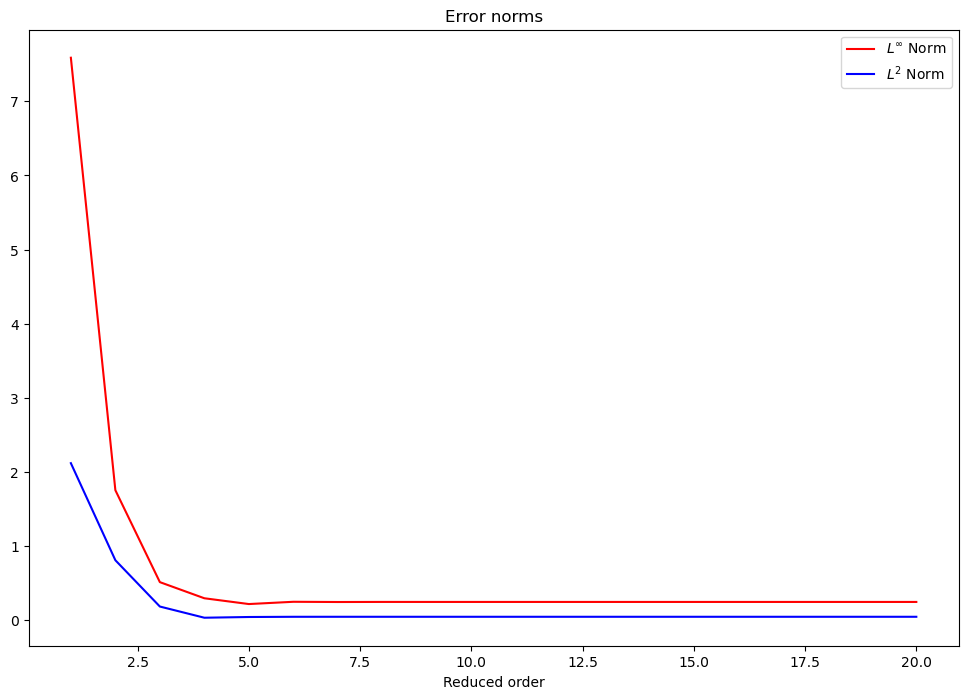

In [215]:
# Error norm plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
ax.plot(order_list, linf_list, label = r"$L^\infty$ Norm", color='red', ms = 0.8)
ax.plot(order_list, l2_list, label = r"$L^2$ Norm", color='blue', ms = 0.9)
ax.set_title("Error norms")
ax.set_xlabel("Reduced order")
ax.legend()

# Show the plot
plt.show()